# Download dataset and unzip in /datasets

## Dataset links

In [ ]:
# RTTS Task-Driven Dataset (for evaluation of hazy object detection tasks)
# https://utexas.app.box.com/s/2yekra41udg9rgyzi3ysi513cps621qz

In [ ]:
# RESIDE-OTS Synthetic Dataset containing clear and synthetic hazy images for training of dezaher networks
# https://utexas.app.box.com/s/25idwrsn890w03grdr6pls28cy38r91i/folder/132139232193

# Visualize Dataset

In [1]:


from omegaconf import OmegaConf
import os
os.chdir("../")

In [2]:
cfg = OmegaConf.load("configs/config.yaml")
cfg.dataset.root = os.path.abspath(cfg.dataset.root)

In [3]:
from dataloaders import RTTSDataset
dataset = RTTSDataset(
    cfg=cfg,
    image_set="demo_test", # oder aus config.training.split
)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ibrak\\PycharmProjects\\jetson-hazy-detection\\datasets\\hazy-no-bb\\ImageSets\\Main\\demo_test.txt'

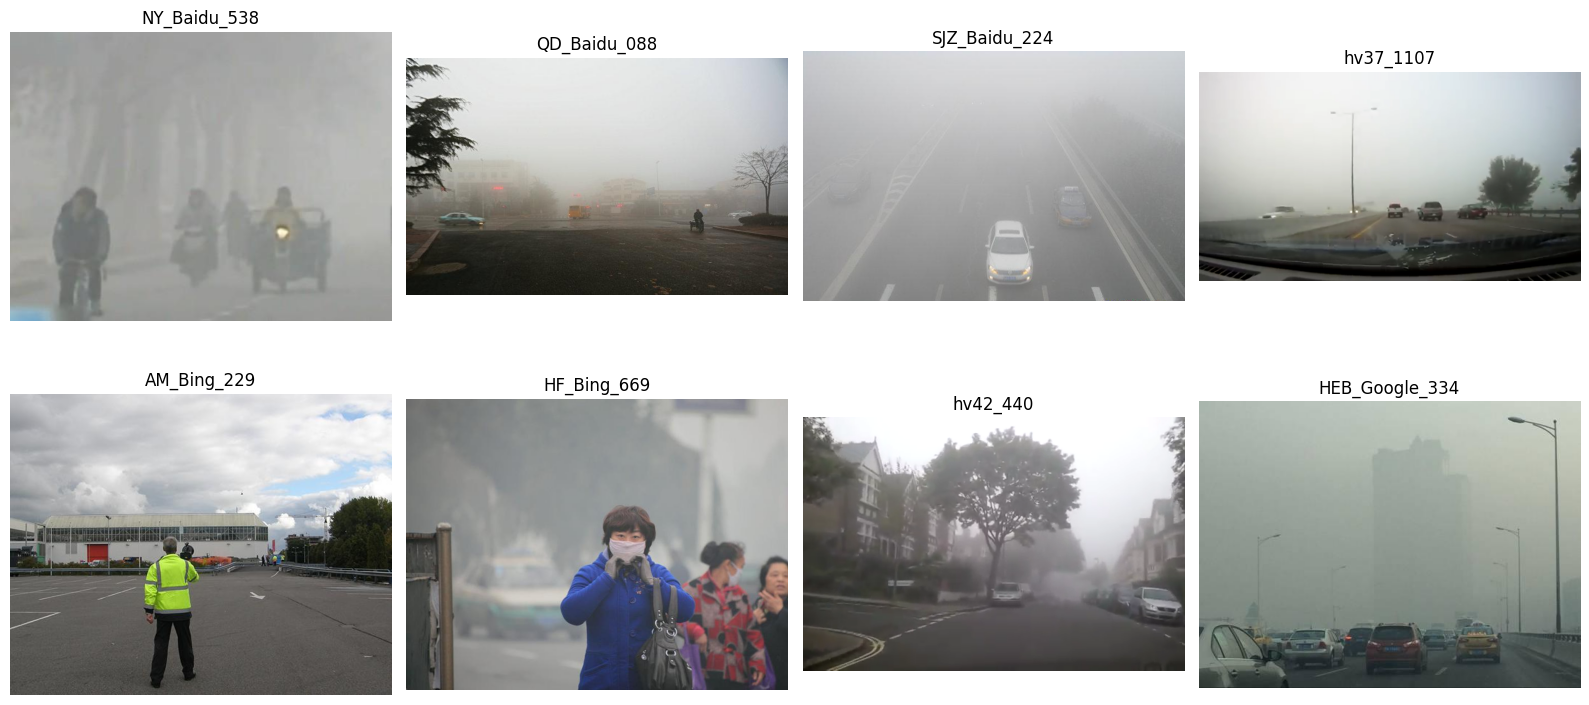

In [3]:
def visualize_rtts_batch(dataset, num_samples=8, cols=4):
    """
    Zieht zufällige Bilder aus dem Dataset und zeigt sie in Jupyter an.
    """
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img, info = dataset[idx]
        
        axes[i].imshow(img)
        
        title = info if isinstance(info, str) else f"ID: {info['image_id'].item()}"
        axes[i].set_title(title)
        axes[i].axis('off')

        if isinstance(info, dict) and "boxes" in info:
            for box in info["boxes"]:
                xmin, ymin, xmax, ymax = box
                rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                     fill=False, color='red', linewidth=2)
                axes[i].add_patch(rect)

    plt.tight_layout()
    plt.show()

visualize_rtts_batch(dataset, num_samples=8)

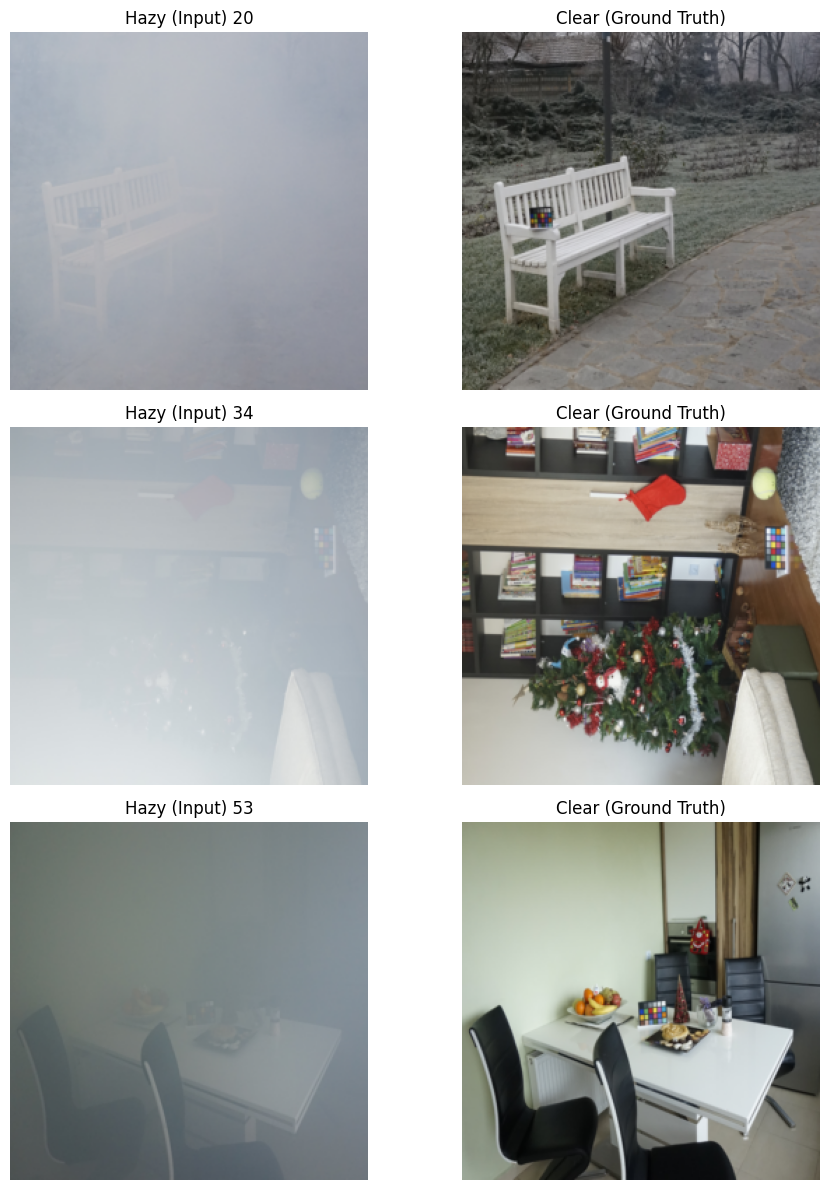

In [3]:
from torchvision import transforms
from dataloaders import PairedDataset

# 1. Einfache Transforms für den Test
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = PairedDataset(cfg, transforms=test_transform)

def check_pairs(dataset, n=3):
    plt.figure(figsize=(10, n * 4))
    for i in range(n):
        idx = np.random.randint(len(dataset))
        hazy, clear = dataset[idx]
        
        # Zurück zu PIL/Numpy für die Anzeige
        hazy_np = hazy.permute(1, 2, 0).numpy()
        clear_np = clear.permute(1, 2, 0).numpy()
        
        plt.subplot(n, 2, 2*i + 1)
        plt.imshow(hazy_np)
        plt.title(f"Hazy (Input) {idx}")
        plt.axis('off')
        
        plt.subplot(n, 2, 2*i + 2)
        plt.imshow(clear_np)
        plt.title(f"Clear (Ground Truth)")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

check_pairs(dataset)

# Train Loop

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from omegaconf import OmegaConf
import os
os.chdir("../")

In [2]:
cfg = OmegaConf.load("configs/config.yaml")
cfg.dataset.root = os.path.abspath(cfg.dataset.root)

In [4]:
from train import train
train(cfg)


🚀 Training auf cpu
📁 Run directory: ./checkpoints\run_20260228_044539

MODEL INFORMATION
Model name              : LCANet
Device                  : cpu
Total parameters        : 71,573
Trainable parameters    : 71,573
Train: 400 | Val: 100



Training:   0%|          | 0/20 [00:00<?, ?epoch/s]C:\Users\ibrak\PycharmProjects\jetson-hazy-detection\.venv\lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
Training:   5%|▌         | 1/20 [01:25<26:58, 85.19s/epoch]

Epoch [1/20] | Loss: 0.0742 | PSNR: 11.38 | SSIM: 0.545 | LR: 1.00e-04 | 85.2s


Training:  10%|█         | 2/20 [02:56<26:34, 88.56s/epoch]

Epoch [2/20] | Loss: 0.0495 | PSNR: 15.86 | SSIM: 0.613 | LR: 1.00e-04 | 90.9s


Training:  15%|█▌        | 3/20 [04:22<24:50, 87.70s/epoch]

Epoch [3/20] | Loss: 0.0201 | PSNR: 17.63 | SSIM: 0.648 | LR: 1.00e-04 | 86.7s


Training:  20%|██        | 4/20 [05:49<23:14, 87.15s/epoch]

Epoch [4/20] | Loss: 0.0195 | PSNR: 17.70 | SSIM: 0.654 | LR: 1.00e-04 | 86.3s


Training:  20%|██        | 4/20 [07:01<28:07, 105.46s/epoch]


KeyboardInterrupt: 

# Benchmark

Create Dataloader

In [3]:
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms
from dataloaders import ResideOTS
    
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = ResideOTS(cfg, transforms=transform)
dataset = Subset(dataset, range(200))
val_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
len(dataset)

200

### FFANet from official Paper

In [5]:
import torch
import torch.nn as nn 
from models.ffa_net import FFA
from evaluation.evaluation import calculate_psnr_ssim
from evaluation import benchmark_single_image

model_dir = "./pretrained_models/ots_train_ffa_3_19.pk"

device='cuda' if torch.cuda.is_available() else 'cpu'
ckp=torch.load(model_dir,map_location=device, weights_only=False)
net=FFA(gps=3,blocks=19)
net=nn.DataParallel(net)
net.load_state_dict(ckp['model'])
#print(net)

device = torch.device(device)
benchmark_single_image(net, device)


Inference Benchmark (cpu)
Avg time: 3522.47 ms
FPS:      0.28


(3522.4733659997582, 0.28389142971310366)

In [ ]:
psnr, ssim = calculate_psnr_ssim(net, val_loader, device=device, out_dir="eval")
print(f"psnr: {psnr}, ssim: {ssim}")

### AODNet (own implementation)

In [6]:
from models.aod_net import AODnet
device='cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

net = AODnet().to(device)
benchmark_single_image(net, device)


Inference Benchmark (cpu)
Avg time: 14.04 ms
FPS:      71.25


(14.035616000182927, 71.24731825001247)

### LCANet (Autoencoder)

In [7]:
from models.lca_net import LCANet
device='cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

net = LCANet().to(device)
benchmark_single_image(net, device)


Inference Benchmark (cpu)
Avg time: 85.29 ms
FPS:      11.72


(85.29034399893135, 11.724656662336004)